# Introduction

The preprocessing of the California Fire Perimeters dataset involved several crucial steps, from data acquisition and format conversion to spatial filtering and visualization, providing valuable insights into wildfire patterns, particularly within the Los Angeles city boundary.

**Data Acquisition and Preparation:**

* The **California Fire Perimeters dataset**, sourced from CAL FIRE, was successfully downloaded as a GeoJSON file. This dataset covers fires across California back to 1878 and is updated annually.
* The GeoJSON data was then converted to a CSV format and subsequently loaded into a **GeoDataFrame** for efficient spatial operations. The initial statewide dataset contains 22,810 records with 22 columns, encompassing fire details from 1878 to 2025.

**Spatial Filtering and Clipping for Los Angeles:**

* The **Los Angeles city boundary** was downloaded and used as a spatial reference.
* Two distinct spatial operations were performed on the California fire data relative to the Los Angeles city boundary:
    * **Filtering by Intersection:** This operation identified 458 fire perimeters that **intersected** with (i.e., touched or overlapped) the Los Angeles city boundary. The resulting "unclipped" fires show the full extent of these perimeters, some of which extend significantly outside the city limits.
    * **Clipping:** This operation precisely cut the fire perimeters to only include the portions that fall strictly **within** the Los Angeles city boundary. The "clipped" fires visually represent only the burnt areas inside the city, providing a more accurate view of the direct impact within the urban area.

**Insights from Visualizations:**

* **Original vs. Clipped Comparison:** Visualizations clearly demonstrate the difference between the "unclipped" fires (showing their full extent even if partially outside the boundary) and the "clipped" fires (showing only the portions within the boundary). This highlights the importance of choosing the appropriate spatial operation (intersection versus clipping) based on the analytical objective.
* **Grouping by Year:** Fires were color-coded by their 'YEAR\_' of occurrence, allowing for a chronological visual analysis of fire activity around and within Los Angeles. The range of years for fires intersecting LA spans from 1878 to 2025, with unique values observed for each year.
* **Grouping by Agency:** Visualizing fires by the responsible 'AGENCY' reveals which entities manage or respond to fires in and around the Los Angeles area, such as CCO (Contract County), CDF (CAL FIRE), LRA (Local Responsibility Area), NPS (National Park Service), and USF (US Forest Service).
* **Grouping by Cause:** The 'CAUSE' attribute categorizes fires (e.g., lightning, equipment use, smoking), providing insights into common ignition sources in the region. The scale of causes ranges from 2 to 14, suggesting various contributing factors.

**Data Characteristics and Limitations:**

* The dataset provides detailed attributes for each fire, including 'OBJECTID', 'FIRE\_NAME', 'GIS\_ACRES', and 'ALARM\_DATE'.
* The official data description from CAL FIRE clarifies the criteria for data collection (e.g., fires $\ge$ 10 acres in timber, $\ge$ 50 acres in brush, or $\ge$ 300 acres in grass, and/or $\ge$ 3 damaged/destroyed residential or commercial structures, and/or caused $\ge$ 1 fatality).
* It also highlights **discrepancies with the CAL FIRE Redbook Large Damaging Fires**, enumerating specific historical fires missing from the digital perimeter data.

# Import libraries

In [1]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Download raw `GeoJSON` dataset

Data source: https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/ArcGIS/rest/services/California_Historic_Fire_Perimeters/FeatureServer/0

In [2]:
genjson_filenames = [ 
    "/app/working/data/california_fire_perimeters_0.geojson", 
    #"/app/working/data/california_fire_perimeters_1.geojson"
]
urls = [
    "https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/ArcGIS/rest/services/California_Historic_Fire_Perimeters/FeatureServer/0/query", 
    # The following is large scale wildfire (> 5000 acers), which is already included in the first url, the full one
    #"https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/ArcGIS/rest/services/California_Historic_Fire_Perimeters/FeatureServer/1/query" 
]

for i, url in enumerate(urls):
    if os.path.exists(genjson_filenames[i]):
        print(f"File already exists - {genjson_filenames[i]}. Skipping download.")
        continue

    all_features = []
    offset = 0
    page_size = 2000

    while True:
        params = {
            "where": "1=1",
            "outFields": "*",
            "f": "geojson",
            "resultOffset": offset,
            "resultRecordCount": page_size
        }

        response = requests.get(url, params=params)
        data = response.json()

        if "features" not in data or not data["features"]:
            break

        all_features.extend(data["features"])
        offset += page_size

    with open(genjson_filenames[i], "w") as f:
        json.dump({
            "type": "FeatureCollection",
            "features": all_features
        }, f)

    print(f"Download complete - {genjson_filenames[i]}.")

File already exists - /app/working/data/california_fire_perimeters_0.geojson. Skipping download.


# Convert `GeoJSON` to `CSV`

In [3]:
csv_filenames = [ 
    "/app/working/data/california_fire_perimeters_0.csv", 
    #"/app/working/data/california_fire_perimeters_1.csv"
]

for i, geojson in enumerate(genjson_filenames):
    if os.path.exists(csv_filenames[i]):
        print(f"File already exists - {csv_filenames[i]}. Skipping conversion.")
        continue
        
    with open(geojson) as f:
        geojson_data = json.load(f)
    
    records = [
        {**feature["properties"], "geometry": shape(feature["geometry"])}
        for feature in geojson_data["features"]
    ]
    
    gdf = gpd.GeoDataFrame(records)
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)
    gdf.to_csv(csv_filenames[i], index=False)
    print(f"Conversion complete - {csv_filenames[i]}.")

File already exists - /app/working/data/california_fire_perimeters_0.csv. Skipping conversion.


# Read the `CSV` and make plots

In [4]:
def read_geo_df(path: str):
    df = pd.read_csv(path)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs("EPSG:4326", inplace=True)
    return df, gdf

def print_df_info(df, name):
    print(f"--- Info for {name} ---")
    print("Dimensions:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique YEAR_ values:", df['YEAR_'].unique())
    print()

In [5]:
ca_fire_0_df, ca_fire_0_gdf = read_geo_df("/app/working/data/california_fire_perimeters_0.csv")
print_df_info(ca_fire_0_gdf, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (22810, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2024. 2023. 2022. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014.
 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002.
 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1994. 1993. 1992. 1991. 1990.
 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979. 1978.
 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967. 1966.
 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955. 1954.
 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1945. 1944. 1943. 1942.
 1941. 1940. 1939. 1938. 1937. 1936. 1935. 1934. 1933. 1932. 1931. 1930.
 1929. 1928. 1927. 1926. 1925. 1924. 1923. 1922. 1921. 1920. 1

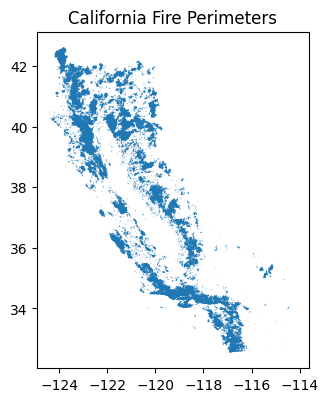

In [6]:
ca_fire_0_gdf.plot(figsize=(3.5, 5))
plt.title("California Fire Perimeters")
plt.show()

# Extract fires only happened inside the Los Angeles city boundary

In [7]:
def filter_fires_in_boundary(fire_gdf, boundary_gdf, mode="within"):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    boundary_union = boundary_gdf.geometry.union_all()
    
    if mode == "within":
        filtered_fires = fire_gdf[fire_gdf.geometry.within(boundary_union)]
    elif mode == "intersects":
        filtered_fires = fire_gdf[fire_gdf.geometry.intersects(boundary_union)]
    else:
        raise ValueError("mode must be 'within' or 'intersects'")
    
    return filtered_fires

def fix_invalid_geometries(gdf):
    # Attempt to fix invalid geometries using buffer(0)
    gdf['geometry'] = gdf.geometry.buffer(0)
    # Drop any that remain invalid (optional)
    gdf = gdf[gdf.is_valid]
    return gdf

def clip_fires_to_boundary(fire_gdf, boundary_gdf):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    fire_gdf = fix_invalid_geometries(fire_gdf)
    
    boundary_union = boundary_gdf.geometry.union_all()
    clipped_fires = gpd.clip(fire_gdf, boundary_union)
    return clipped_fires

In [8]:
# First get the LA city boundary
url = "https://hub.arcgis.com/api/v3/datasets/09f503229d37414a8e67a7b6ceb9ec43_7/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
output_path = "/app/working/data/la_city_boundary.geojson"

if not os.path.exists(output_path):
    response = requests.get(url)
    response.raise_for_status()
    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"LA city boundary saved to {output_path}")
else:
    print(f"File already exists at {output_path}, skipping download.")

File already exists at /app/working/data/la_city_boundary.geojson, skipping download.


<Axes: >

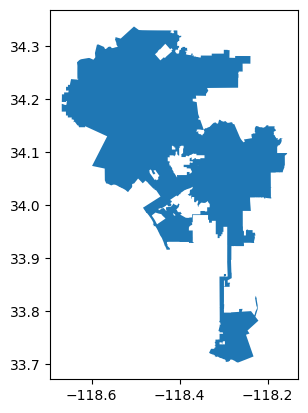

In [9]:
la_boundary = gpd.read_file('/app/working/data/la_city_boundary.geojson')
la_boundary.plot()

In [10]:
# Filter out the fires around and inside the LA city boundary
la_fire_0_gdf = filter_fires_in_boundary(ca_fire_0_gdf, la_boundary, mode="intersects")
print_df_info(la_fire_0_gdf, "ca_fire_0_df")

# Clip the fires that are strictly inside the LA city
la_fire_0_gdf_clipped = clip_fires_to_boundary(ca_fire_0_gdf, la_boundary)
print_df_info(la_fire_0_gdf_clipped, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014. 2013. 2012. 2010.
 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2000. 1999. 1994. 1993. 1992.
 1991. 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979.
 1978. 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967.
 1966. 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955.
 1954. 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1944. 1943. 1942.
 1941. 1938. 1937. 1935. 1933. 1932. 1929. 1927. 1925. 1924. 1923. 1922.
 1921. 1919. 1918. 1916. 1915. 1914. 1913. 1911. 1910. 1878.]

--- Info for ca_fire_0_df ---
Dimensions: (458, 22)
Columns: ['OBJECTID', 

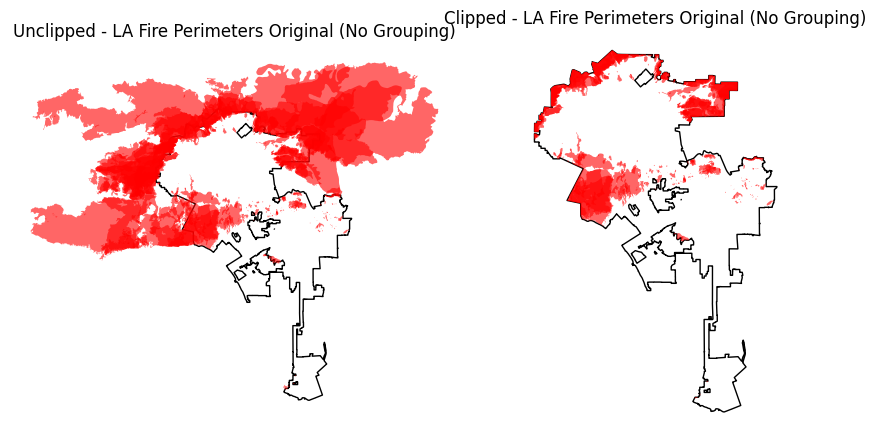

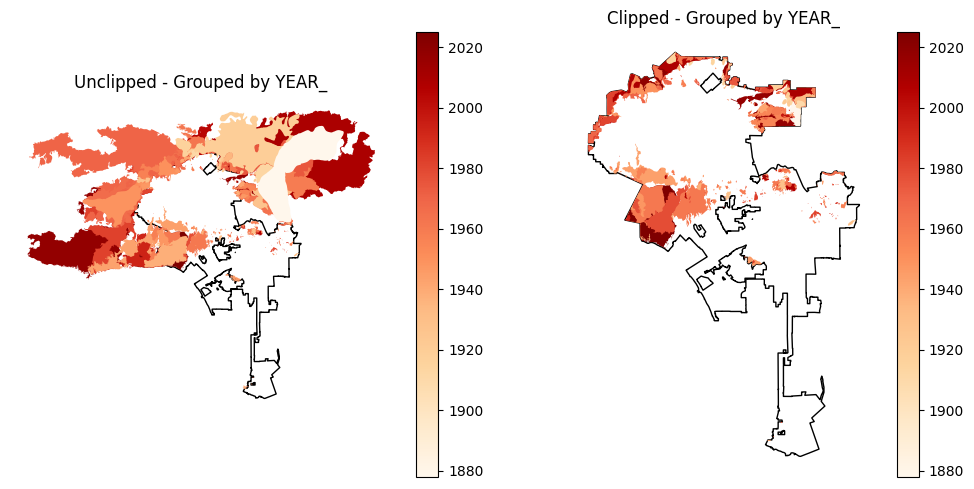

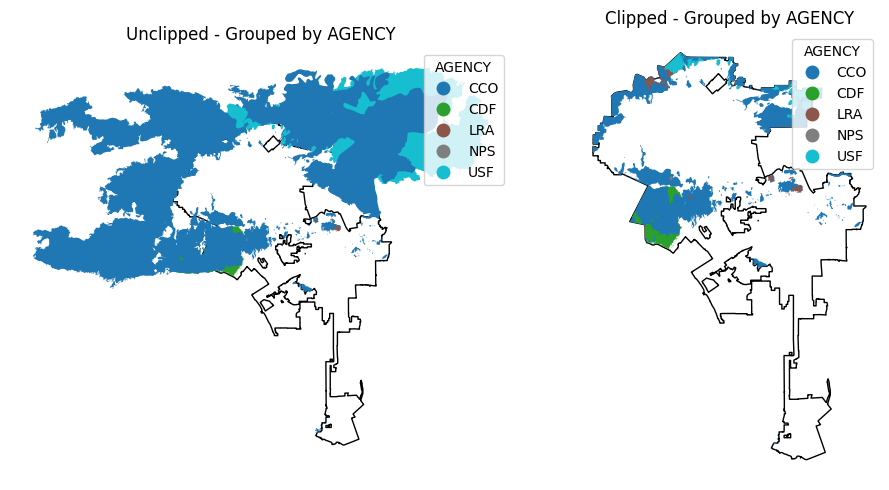

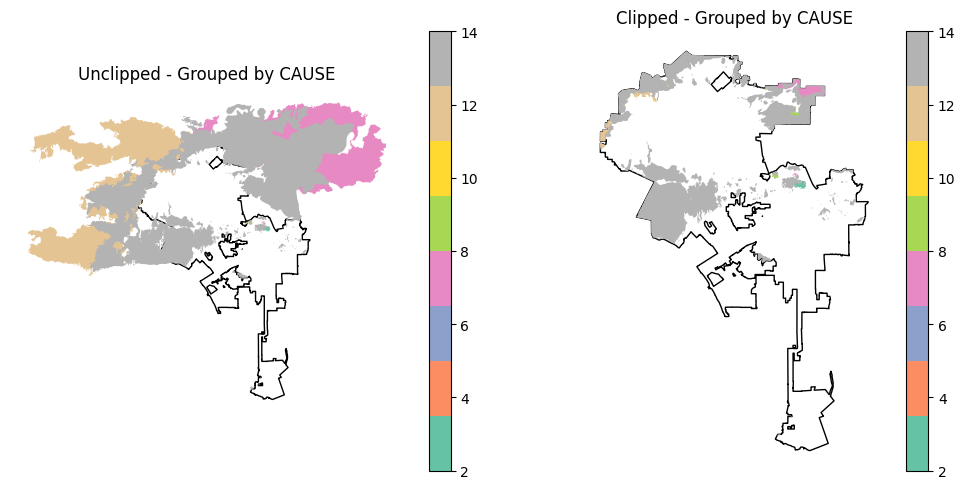

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

# Unclipped original
la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
la_fire_0_gdf.plot(ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Unclipped - LA Fire Perimeters Original (No Grouping)')
axes[0].axis('off')

# Clipped original
la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
la_fire_0_gdf_clipped.plot(ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Clipped - LA Fire Perimeters Original (No Grouping)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

group_cols = ['YEAR_', 'AGENCY', 'CAUSE']
colormaps = ['OrRd', 'tab10', 'Set2']

for group_col, cmap in zip(group_cols, colormaps):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    col_dtype = la_fire_0_gdf[group_col].dtype
    is_categorical = is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype)

    legend_args = {'legend': True}
    if is_categorical:
        legend_args['legend_kwds'] = {'title': group_col}

    # Unclipped plot
    la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
    la_fire_0_gdf.plot(
        ax=axes[0],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[0].set_title(f'Unclipped - Grouped by {group_col}')
    axes[0].axis('off')

    # Clipped plot
    la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
    la_fire_0_gdf_clipped.plot(
        ax=axes[1],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[1].set_title(f'Clipped - Grouped by {group_col}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Take a close look to the LA only data

In [12]:
print(la_fire_0_gdf)

       OBJECTID   YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  \
0             1  2025.0    CA    CDF     LDF  PALISADES  00000738   
4             5  2025.0    CA    CDF     LDF      HURST  00003294   
1175       1177  2021.0    CA    LRA     LAC  PALISADES  00001448   
1518       1520  2021.0    CA    LRA     LDF       PEAK  00001026   
1972       1974  2020.0    CA    CCO     LAC    TOPANGA  00216968   
...         ...     ...   ...    ...     ...        ...       ...   
22265     22267  1913.0    CA    USF     ANF             00000000   
22428     22430  1911.0    CA    USF     ANF             00000000   
22607     22609  1910.0    CA    USF     ANF             00000000   
22638     22640  1910.0    CA    USF     ANF             00000000   
22732     22734  1878.0    CA    CCO     LAC             00000000   

         ALARM_DATE     CONT_DATE  CAUSE  ...     GIS_ACRES  \
0      1.736237e+12  1.738310e+12     14  ...  23448.880000   
4      1.736237e+12  1.736410e+12     14  ...